# IMPORTS

In [1]:
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import torch
import torch.nn as nn
import time
import itertools

c:\Users\anike\anaconda3\envs\data-science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# PROBLEM STATEMENT

###### It is difficult to predict the price of a stock in the future manually as it is difficult to go through all of the indicators and check which one works better for which stock and even then stock data is susceptible to randomness. Therefore, here we are developing a single system to predict the future price of any stock by dynamically selecting the best indicators and the best model for the stock.

# GET DATA

In [2]:
SYMBOL = "AAPL"
START =  "2017-01-01"

In [3]:
def get_data(symbol, date):
    # set company
    SYMBOL = symbol
    # set date range
    start = datetime.datetime(*[int(i) for i in date.split('-')])
    end = (datetime.datetime.today() - datetime.timedelta(days = 1)).strftime('%Y-%m-%d')
    # get data
    df = yf.download(tickers = SYMBOL, start = start, end = end)
    return df

In [4]:
df = get_data(SYMBOL, START)

[*********************100%***********************]  1 of 1 completed


# EDA

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.219837,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.189365,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.327637,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.632294,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.885391,134247600


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1.418000e+03
mean,84.136412,85.109700,83.223685,84.214448,82.856058,1.174158e+08
std,46.861514,47.484869,46.261767,46.902626,47.346861,5.443264e+07
min,28.950001,29.082500,28.690001,29.004999,27.189365,4.100000e+07
25%,43.629999,43.849375,43.294374,43.639998,41.822063,8.196360e+07
50%,60.187500,61.243750,59.297499,60.290001,59.303144,1.032840e+08
75%,128.957504,130.682507,127.747501,129.582500,128.453659,1.365305e+08
max,182.630005,182.940002,179.119995,182.009995,181.259918,4.479400e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1418 entries, 2017-01-03 to 2022-08-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1418 non-null   float64
 1   High       1418 non-null   float64
 2   Low        1418 non-null   float64
 3   Close      1418 non-null   float64
 4   Adj Close  1418 non-null   float64
 5   Volume     1418 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 77.5 KB


In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

###### Even though we have no null values we have to fill in values for the missing dates in the data

<AxesSubplot:>

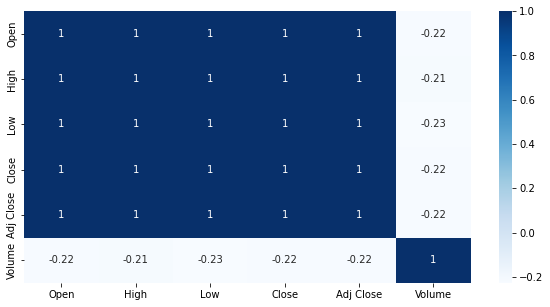

In [9]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)

###### volume has the least correlation with any of the other features
###### lets try adding other features

In [10]:
df['open-high']  = df['Open']  - df['High']
df['open-low']   = df['Open']  - df['Low']
df['close-high'] = df['Close'] - df['High']
df['close-low']  = df['Close'] - df['Low']
df['high-low']   = df['High']  - df['Low']
df['open-close'] = df['Open']  - df['Close']

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,open-high,open-low,close-high,close-low,high-low,open-close
Date,,,,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.219837,115127600,-0.132500,0.260000,-0.045000,0.347500,0.392500,-0.087500
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.189365,84472400,-0.165001,0.025000,-0.122501,0.067499,0.190001,-0.042500
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.327637,88774400,-0.235001,0.027500,-0.062500,0.200001,0.262501,-0.172501
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.632294,127007600,-0.345001,0.077499,-0.062500,0.360001,0.422501,-0.282501
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.885391,134247600,-0.370001,0.002499,-0.110001,0.262499,0.372499,-0.260000


<AxesSubplot:>

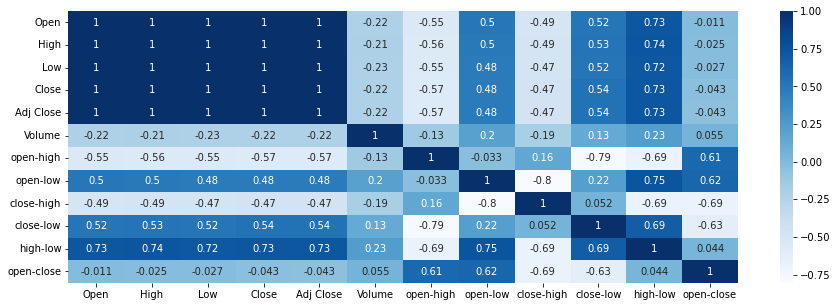

In [12]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)

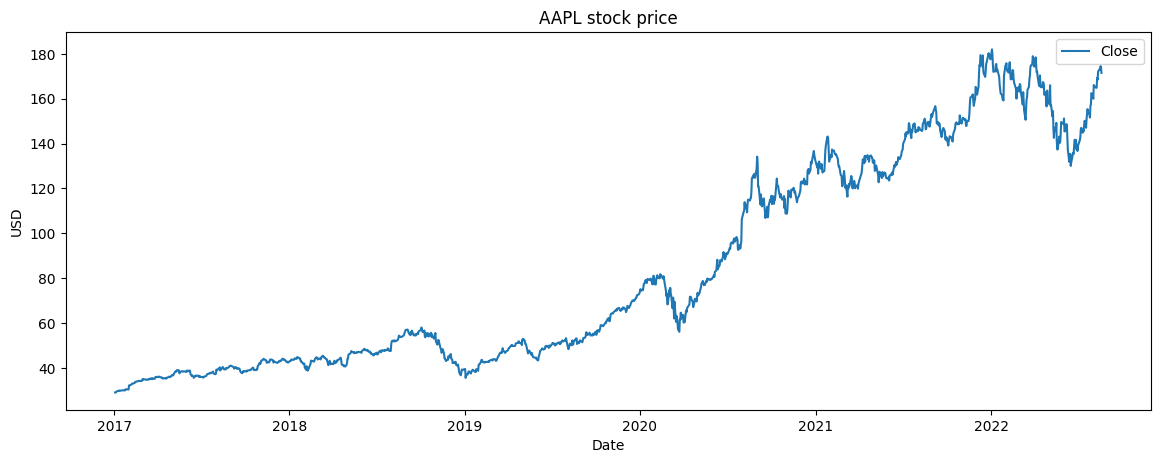

In [13]:
plt.figure(figsize = (14, 5), dpi = 100)
plt.plot(df.index, df['Close'], label = 'Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title(SYMBOL + ' stock price')
plt.legend()
plt.show()

###### The stock price of Apple has been on a steep rise since mid 2020 which is when the world was hit by pandemic showing that the company has handled the pandemic well!! 

# FEATURE ENGINEERING

### FILLING MISSING DATES

In [14]:
def fill_missing(df):
    # remove date as index
    df = df.reset_index()
    # change datatype of Date column
    df.Date = df.Date.astype('str')
    # getting list of complete dates from the range
    dates = pd.date_range(start = df.iloc[0]['Date'], end = df.iloc[-1]['Date'], freq = 'D').astype('str')
    # making new full dataframe
    new_df = pd.DataFrame(columns = df.columns)
    for date in dates:
        if len(df[df['Date'] == date]):
            new_df.loc[len(new_df.index)] = df[df['Date'] == date].values[0]
        else:
            # filling missing date with previous date values
            row = new_df.iloc[len(new_df.index)-1].values
            row[0] = date
            new_df.loc[len(new_df.index)] = row
    return new_df

In [15]:
df.shape

(1418, 12)

In [16]:
df = fill_missing(df)

In [17]:
df.shape

(2055, 13)

###### MISSING DATES LIKE PUBLIC HOLIDAYS WERE FILLED

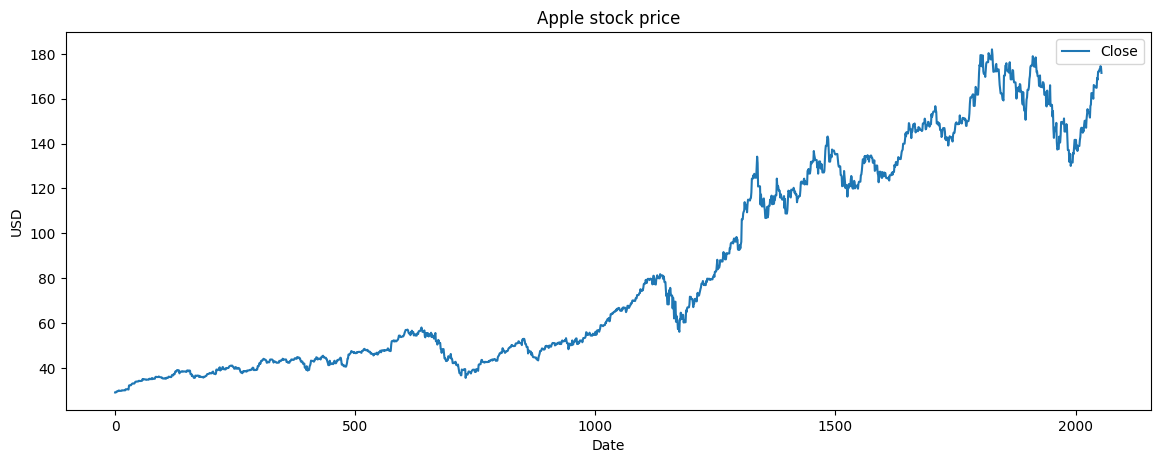

In [18]:
plt.figure(figsize = (14, 5), dpi = 100)
plt.plot(df.index, df['Close'], label = 'Close')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Apple stock price')
plt.legend()
plt.show()

### ADDING TECHNICAL INDICATORS

In [19]:
def tech_indi(df):
    # 44 days moving average
    df['ma44'] = df['Close'].rolling(window = 44).mean()
    # create 7 and 21 day moving average
    df['ma7'] = df['Close'].rolling(window = 7).mean()
    df['ma21'] = df['Close'].rolling(window = 21).mean()
    # create MACD
    df['26ema'] = df['Close'].ewm(span = 26, adjust = False, min_periods = 26).mean()
    df['12ema'] = df['Close'].ewm(span = 12, adjust = False, min_periods = 12).mean()
    df['MACD'] = (df['12ema'] - df['26ema'])
    # create bollinger bands
    df['20sd'] = df['Close'].rolling(window = 20).std()
    df['upper_band'] = df['Close'].rolling(window = 20).mean() + (df['20sd'] * 2)
    df['lower_band'] = df['Close'].rolling(window = 20).mean() - (df['20sd'] * 2)
    # create exponential moving average
    df['ema'] = df['Close'].ewm(com = 0.5).mean()
    # create momentum
    df['momentum'] = (df['Close'] / 100) - 1
    return df

In [20]:
df = tech_indi(df)

In [21]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,open-high,open-low,close-high,...,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.219837,115127600,-0.132500,0.260000,-0.045000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.037500,-0.709625
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.189365,84472400,-0.165001,0.025000,-0.122501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.013124,-0.709950
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.327637,88774400,-0.235001,0.027500,-0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.109615,-0.708475
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.632294,127007600,-0.345001,0.077499,-0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.357938,-0.705225
4,2017-01-07,29.195000,29.540001,29.117500,29.477501,27.632294,127007600,-0.345001,0.077499,-0.062500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.437976,-0.705225


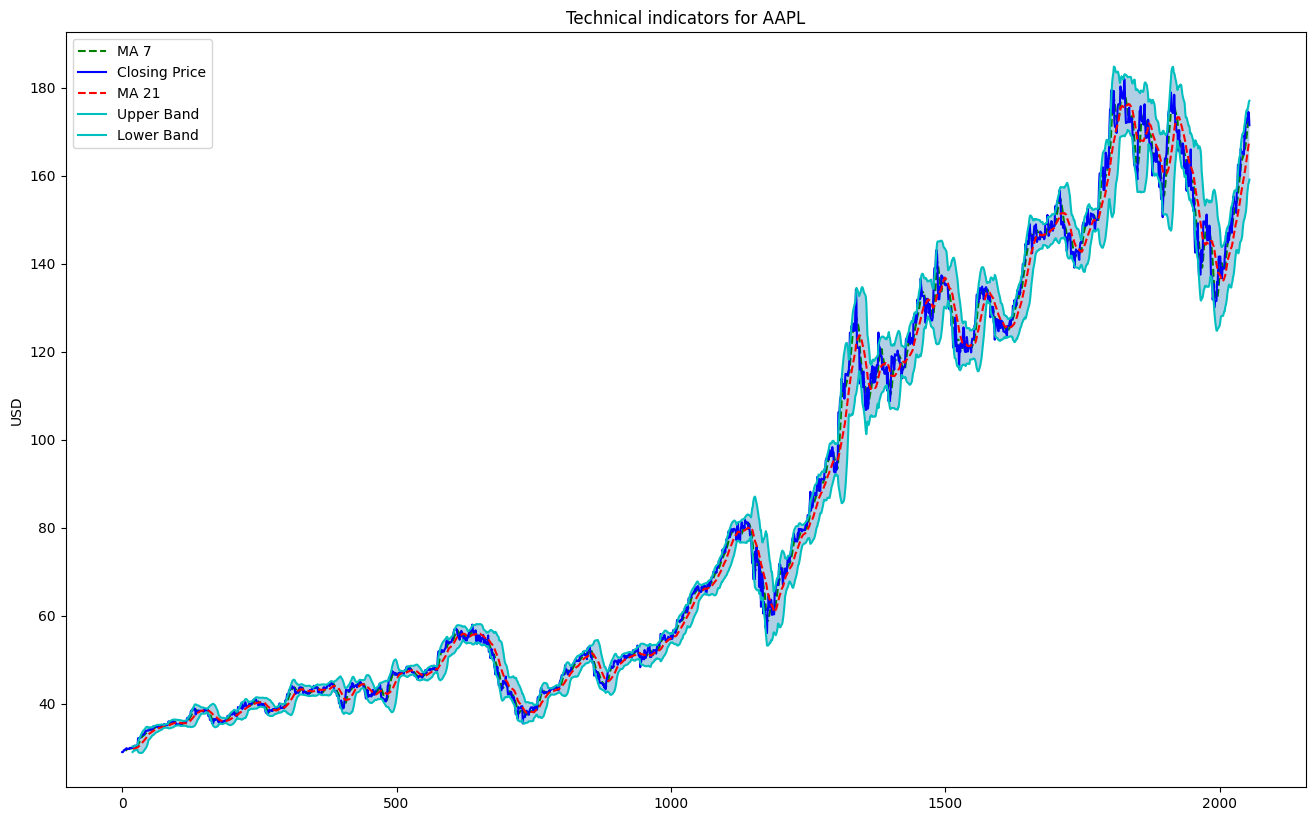

In [22]:
plt.figure(figsize = (16, 10), dpi = 100)
plt.plot(df['ma7'], label = 'MA 7', color = 'g', linestyle = '--')
plt.plot(df['Close'], label = 'Closing Price', color = 'b')
plt.plot(df['ma21'], label = 'MA 21', color = 'r', linestyle = '--')
plt.plot(df['upper_band'], label = 'Upper Band', color = 'c')
plt.plot(df['lower_band'], label = 'Lower Band', color = 'c')
plt.fill_between(df.index, df['lower_band'], df['upper_band'], alpha = 0.35)
plt.title('Technical indicators for {}'.format(SYMBOL))
plt.ylabel('USD')
plt.legend()

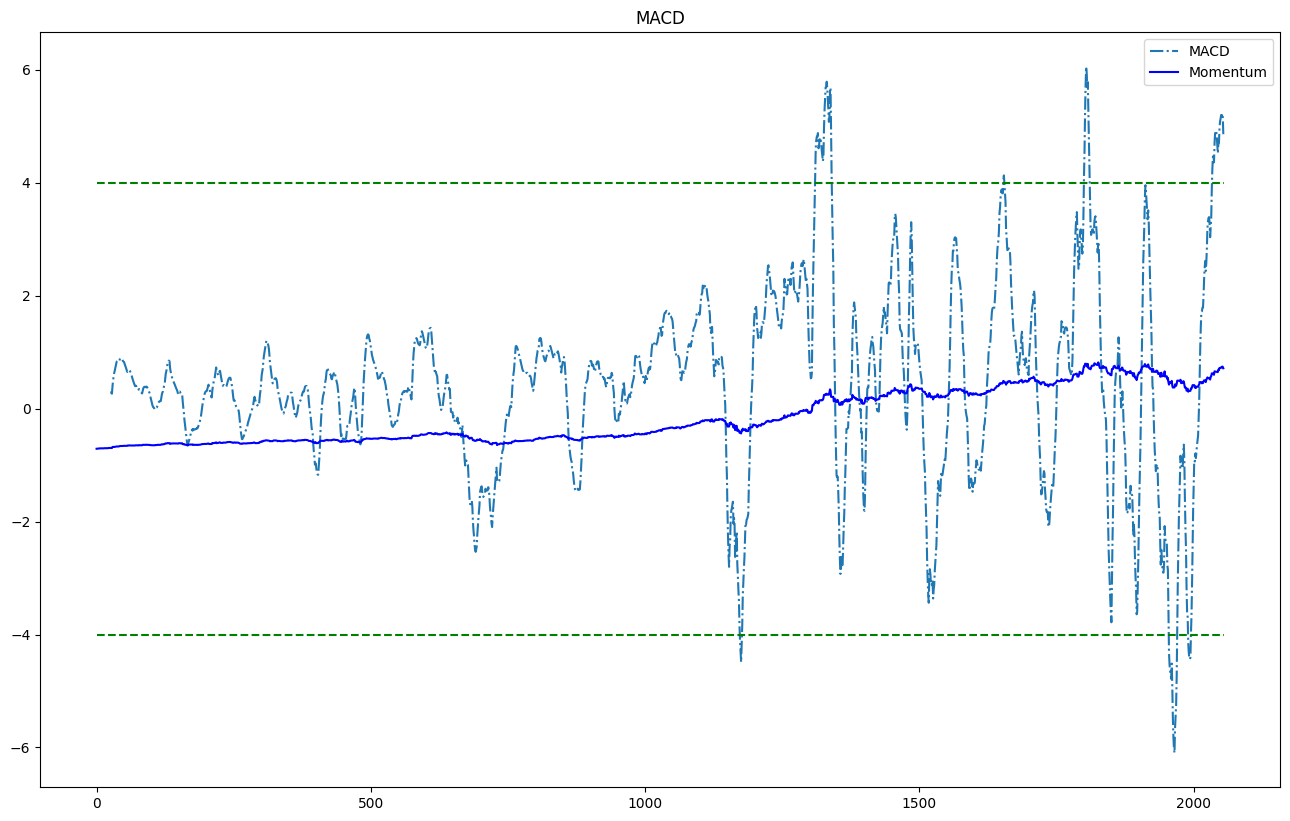

In [23]:
plt.figure(figsize = (16, 10), dpi = 100)
plt.title('MACD')
plt.plot(df['MACD'], label = 'MACD', linestyle = '-.')
plt.hlines(4, 0, df.shape[0], colors = 'g', linestyles = '--')
plt.hlines(-4, 0, df.shape[0], colors = 'g', linestyles = '--')
plt.plot(df['momentum'], label = 'Momentum', color = 'b', linestyle = '-')
plt.legend()

### ANALYSIS OF TIME SERIES USING FOURIER TRANSFORM

In [24]:
close_fft = np.fft.fft(np.asarray(df['Close'].tolist()))
fft_df = pd.DataFrame({'fft': close_fft})

C:\Users\anike\anaconda3\envs\data-science\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


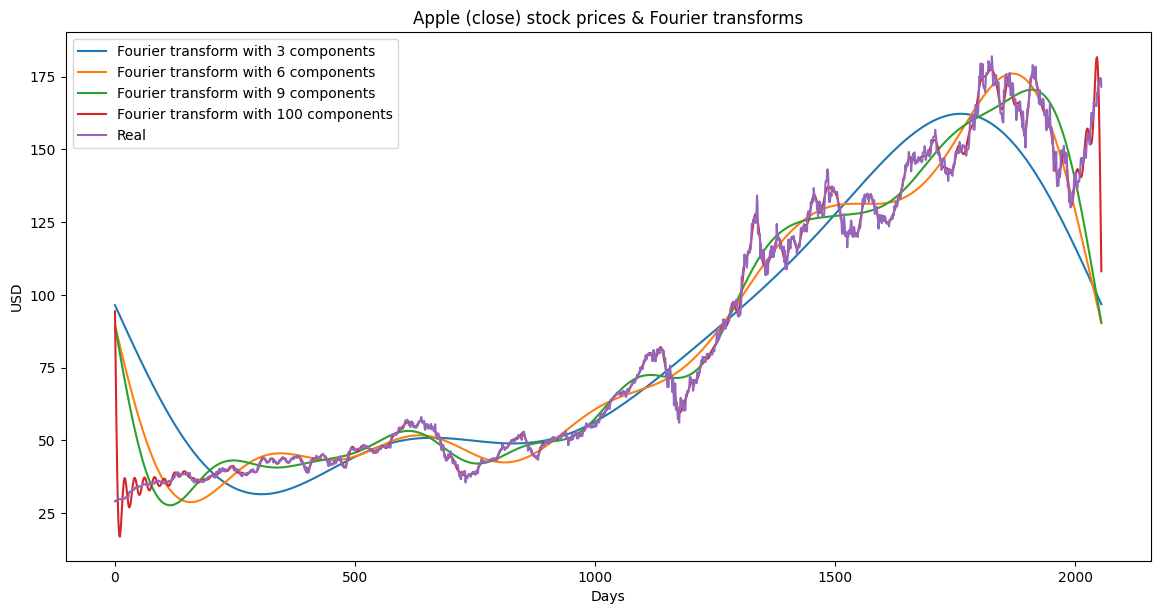

In [25]:
plt.figure(figsize = (14, 7), dpi = 100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10 = np.copy(fft_list)
    fft_list_m10[num_:-num_] = 0
    plt.plot(np.fft.ifft(fft_list_m10), label = 'Fourier transform with {} components'.format(num_))
plt.plot(df['Close'], label = 'Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Apple (close) stock prices & Fourier transforms')
plt.legend()

###### Fourier Transform as indicator helps to extract predominate cycle from a series of data
###### In the above example we can see the spectral component of 100 is closest to the real price so we will move ahead with 100

In [26]:
fft_list = np.asarray(fft_df['fft'].tolist())
fft_list_m10 = np.copy(fft_list)
fft_list_m10[100:-100] = 0
df['Fourier'] = pd.DataFrame(fft_list_m10).apply(lambda x: np.abs(x))

In [27]:
df['Fourier']

0       172824.875078
1        57482.441613
2        22738.356019
3        15994.778885
4        11961.766826
            ...      
2050      8263.142350
2051     11961.766826
2052     15994.778885
2053     22738.356019
2054     57482.441613
Name: Fourier, Length: 2055, dtype: float64

### ADDING MOVEMENT OF PRICE

In [28]:
def price_movement(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['movement'] = scaler.fit_transform(df[['Close']])
    return df

In [29]:
df = price_movement(df)

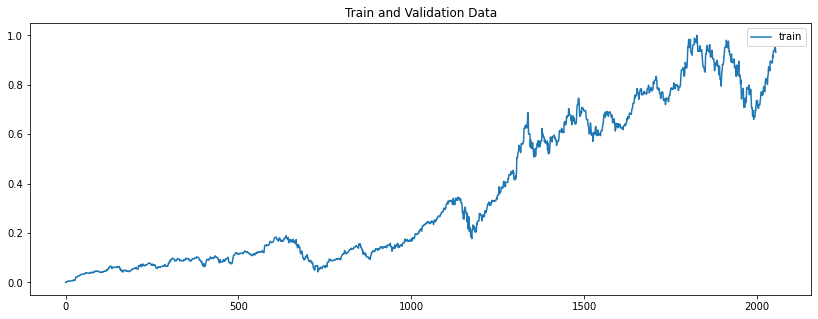

In [30]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df.movement, label = 'train')
plt.legend(loc = 'best')
plt.title("Train and Validation Data")
plt.show()

###### This value shows the movement of the market as predicting prices can be difficult

### ADDING SLOPE TO THE DATA

In [31]:
def slope(df, c):
    df['slope'] = 0
    df['row'] = df.index
    df['slope'] = df['row'].apply(lambda x: (df['Close'][x] - df['Close'][max(0, x - c)]) / c)
    df = df.drop(['row'], axis = 1)
    return df
df = slope(df, 10)

In [32]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,open-high,open-low,close-high,...,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,movement,slope
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.219837,115127600,-0.132500,0.260000,-0.045000,...,NaN,NaN,NaN,NaN,NaN,29.037500,-0.709625,172824.875078,0.000212,0.00000
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.189365,84472400,-0.165001,0.025000,-0.122501,...,NaN,NaN,NaN,NaN,NaN,29.013124,-0.709950,57482.441613,0.000000,-0.00325
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.327637,88774400,-0.235001,0.027500,-0.062500,...,NaN,NaN,NaN,NaN,NaN,29.109615,-0.708475,22738.356019,0.000964,0.01150
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.632294,127007600,-0.345001,0.077499,-0.062500,...,NaN,NaN,NaN,NaN,NaN,29.357938,-0.705225,15994.778885,0.003088,0.04400
4,2017-01-07,29.195000,29.540001,29.117500,29.477501,27.632294,127007600,-0.345001,0.077499,-0.062500,...,NaN,NaN,NaN,NaN,NaN,29.437976,-0.705225,11961.766826,0.003088,0.04400


###### This column shows in which direction the price is moving based on the last n days

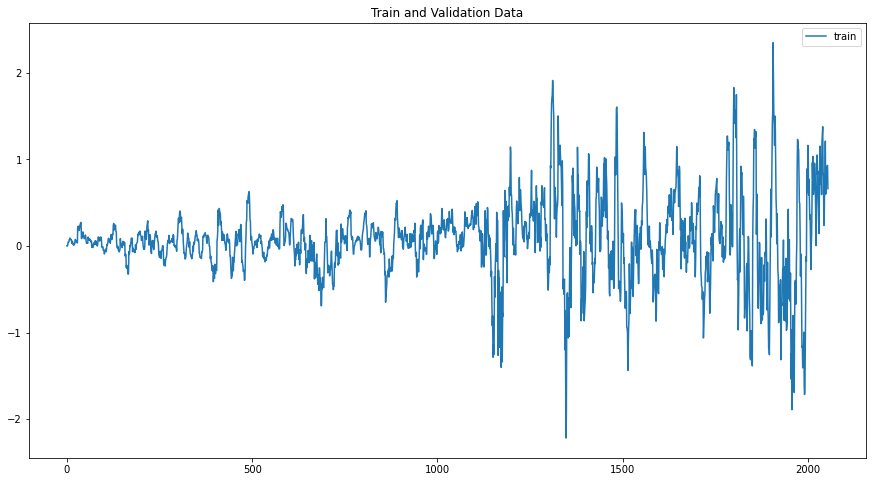

In [33]:
plt.figure(figsize=(15,8))
plt.plot(df.index, df.slope, label = 'train')
plt.legend(loc = 'best')
plt.title("Train and Validation Data")
plt.show()

###### The price fluctuates heavily in the second half of the data

### ANALYSIS OF TIME SERIES USING ARIMA

#### PREROCESSING

In [34]:
# split data into training and validation set
div = int(df.shape[0] * 0.8)
train, val = df[["Date", "Close"]].loc[:div], df[["Date", "Close"]].loc[div:]

In [35]:
# get df into proper format
# train
train['Date'] = pd.to_datetime(train['Date'], format = '%Y-%m-%d')
# train.index = train['Date']
# train.drop("Date", axis = 1, inplace = True)
# val
val['Date'] = pd.to_datetime(val['Date'], format = '%Y-%m-%d')
# val.index = val['Date']
# val.drop("Date", axis = 1, inplace = True)

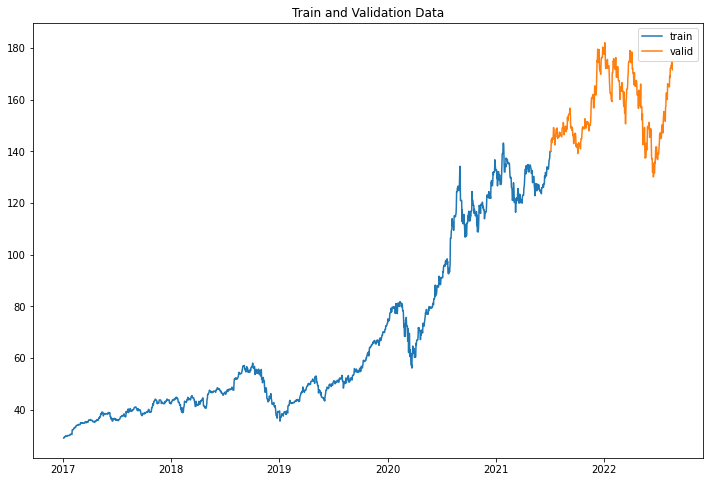

In [36]:
# plt.figure(figsize=(12,8))
# plt.plot(train.index, train, label = 'train')
# plt.plot(val.index, val, label = 'valid')
# plt.legend(loc = 'best')
# plt.title("Train and Validation Data")
# plt.show()
plt.figure(figsize=(12,8))
plt.plot(train.Date, train.Close, label = 'train')
plt.plot(val.Date, val.Close, label = 'valid')
plt.legend(loc = 'best')
plt.title("Train and Validation Data")
plt.show()

#### CHECK STATIONARITY

In [37]:
# Perform Dickey-Fuller test:
def df_test(df):
    dftest = adfuller(df, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [38]:
df_test(train["Close"])

Test Statistic                    0.460118
p-value                           0.983609
#Lags Used                       24.000000
Number of Observations Used    1620.000000
Critical Value (1%)              -3.434393
Critical Value (5%)              -2.863326
Critical Value (10%)             -2.567721
dtype: float64


###### The test statistic is > than critical value. Hence series is not stationary

#### MAKING SERIES STATIONARY

In [39]:
train['Close_log'] = np.log(train['Close'] + 1)
train['Close_log_diff'] = train['Close_log'] - train['Close_log'].shift(1)
train['Close_log_diff'].fillna(0, inplace = True)

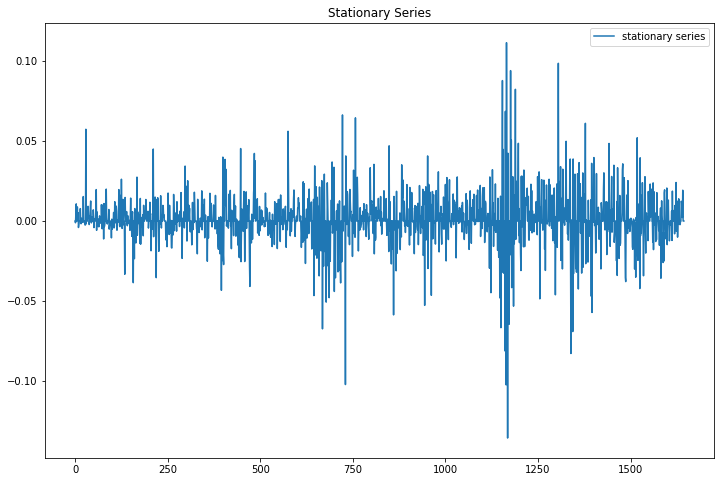

In [40]:
plt.figure(figsize = (12, 8))
plt.plot(train.index, train['Close_log_diff'], label = 'stationary series')
plt.legend(loc = 'best')
plt.title("Stationary Series")
plt.show()

In [41]:
# Perform Dickey-Fuller test:
df_test(train["Close_log_diff"])

Test Statistic                -8.441407e+00
p-value                        1.759143e-13
#Lags Used                     1.900000e+01
Number of Observations Used    1.625000e+03
Critical Value (1%)           -3.434381e+00
Critical Value (5%)           -2.863320e+00
Critical Value (10%)          -2.567718e+00
dtype: float64


###### The test statistic is < than critical value. Hence series is stationary

#### ACF and PACF plots

C:\Users\anike\anaconda3\envs\data-science\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


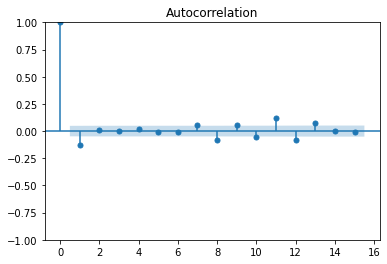

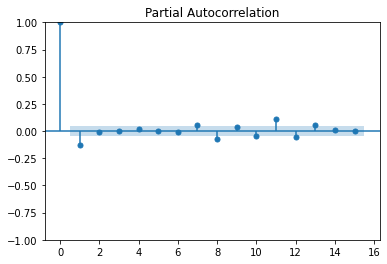

In [42]:
_ = plot_acf(train['Close_log_diff'].dropna(), lags = 15)
_ = plot_pacf(train['Close_log_diff'].dropna(), lags = 15)

###### q value is 1 in ACF chart as the lag value crosses the confidence interval for the first time
###### p value is 1 in PACF chart as the lag value crosses the confidence interval for the first time

#### ARIMA

In [43]:
model = ARIMA(train['Close_log'], order = (1, 1, 1))
model_fit = model.fit()
output = model_fit.forecast(val['Close'].shape[0])

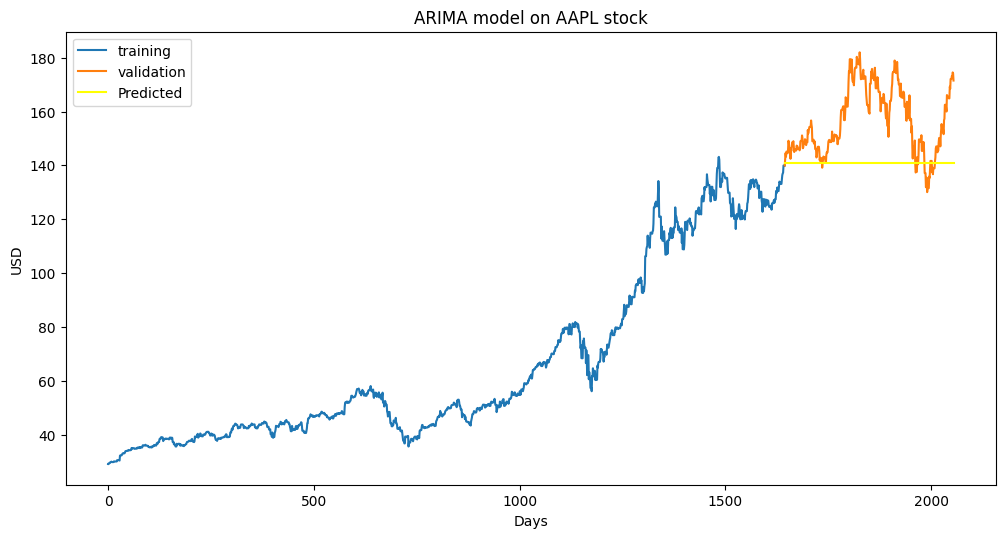

In [44]:
plt.figure(figsize = (12, 6), dpi = 100)
plt.plot(train.index, train['Close'].tolist(), label = 'training')
plt.plot(val.index, val['Close'].tolist(), label = 'validation')
plt.plot(val.index, np.exp(output), color = 'yellow', label = 'Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title(f"ARIMA model on {SYMBOL} stock")
plt.legend()

###### As we can see ARIMA is not able to track prices well, we will move forward with deep learning models

## CHECKING DATA TYPES

In [45]:
df.dtypes

Date           object
Open          float64
High          float64
Low           float64
Close         float64
Adj Close     float64
Volume         object
open-high     float64
open-low      float64
close-high    float64
close-low     float64
high-low      float64
open-close    float64
ma44          float64
ma7           float64
ma21          float64
26ema         float64
12ema         float64
MACD          float64
20sd          float64
upper_band    float64
lower_band    float64
ema           float64
momentum      float64
Fourier       float64
movement      float64
slope         float64
dtype: object

In [46]:
df['Volume'] = df['Volume'].astype('float64')

# FEATURE SELECTION

In [47]:
def feat_select(df, col, spread):
    # make a copy of the dataframe
    fs = df.copy()
    # make target column which is the future value to predict
    ncol = col + "+" + str(spread)
    fs[ncol] = fs[col].shift(-spread)
    fs = fs.dropna()
    # split data into training and validation set
    div = int(fs.shape[0] * 0.8)
    train, val = fs.iloc[:div], fs.iloc[div:]
    tx, ty = train.drop(['Date', ncol], axis = 1), train[ncol]
    vx, vy = val.drop(['Date', ncol], axis = 1), val[ncol]
    # define model
    regressor = xgb.XGBRegressor(
        gamma = 0.0, 
        n_estimators = 300, 
        base_score = 0.7, 
        learning_rate = 0.05
    )
    # fit model
    xgbModel = regressor.fit(tx, ty, eval_set = [(tx, ty), (vx, vy)], verbose = False)
    # plot error
    eval_result = regressor.evals_result()
    training_rounds = range(len(eval_result['validation_0']['rmse']))
    plt.scatter(x = training_rounds, y = eval_result['validation_0']['rmse'], label = 'Training Error')
    plt.scatter(x = training_rounds, y = eval_result['validation_1']['rmse'], label = 'Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    plt.title('Training Vs Validation Error')
    plt.legend()
    plt.show()
    # plot feature importance
    fig = plt.figure(figsize = (8, 8))
    plt.xticks(rotation = 'vertical')
    plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label = tx.columns)
    plt.title('Feature importance of the technical indicators.')
    plt.show()
    # extracting important valiable
    imp_col = [i[0] for i in [i for i in list(zip(tx, xgbModel.feature_importances_)) if i[1] > 0.01]]
    return imp_col

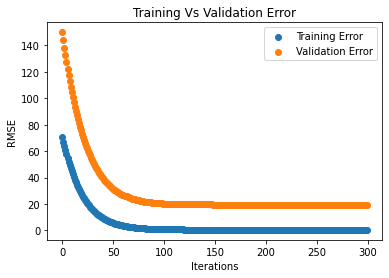

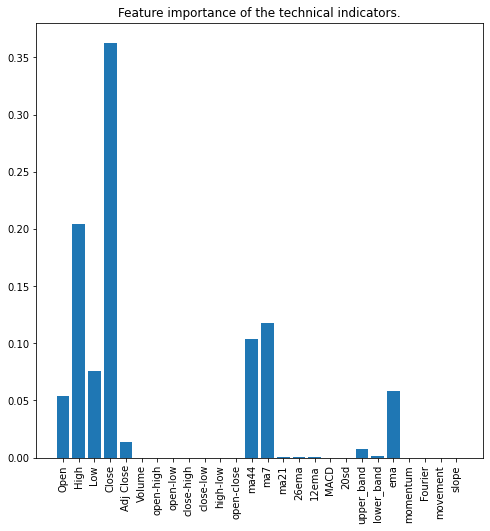

In [50]:
# Find important features based on dependent feature and number of days ahead to predict directly
imp_col = feat_select(df, "Close", 1)

In [51]:
imp_col

['Open', 'High', 'Low', 'Close', 'Adj Close', 'ma44', 'ma7', 'ema']

# MODEL SECLECTION

## ONE SHOT PREDICTION - BATCH WISE

In [52]:
def batch_data_maker(df, peek, lookback, col):
    # name of new column
    ncol = "Pred_" + col
    # save pred column in variable
    ref_col = df[col]
    # removing the future values as they are to be predicted
    data = df[:-peek]
    # adding index
    data['row'] = data.index
    # making the prediction data
    data[ncol] = data['row'].apply(lambda x: ref_col[x: x + peek].values)
    data = data.drop(['row'], axis = 1)
    data = data.dropna()
    # splitting data
    div = int(data.shape[0] * 0.8)
    X = data.drop(ncol, axis = 1)
    Y = data[ncol]
    x_train = X[:div]
    y_train = Y[:div]
    x_val = X[div:]
    y_val = Y[div:]
    # scaling data
    scaler = MinMaxScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    # making into batches
    x_train_batch = []
    y_train_batch = []
    x_val_batch = []
    y_val_batch = []
    for index in range(x_train.shape[0] - lookback): 
        x_train_batch.append(x_train[index: index + lookback])
        y_train_batch.append(y_train.iloc[index + lookback])
    for index in range(x_val.shape[0] - lookback): 
        x_val_batch.append(x_val[index: index + lookback])
        y_val_batch.append(y_val.iloc[index + lookback])    
    r = []
    for i in [x_train_batch, y_train_batch, x_val_batch, y_val_batch]:
        r.append(torch.from_numpy(np.array(i)).float())
    return r

In [55]:
class BATCH_LSTM(nn.Module):
        def __init__(self, ind, hd, nl, od, lookback):
            super(BATCH_LSTM, self).__init__()
            self.hidden_dim = hd
            self.num_layers = nl
            self.lookback = lookback
            self.lstm = nn.LSTM(ind, hd, nl, batch_first = True)
            self.fc = nn.Linear(lookback * hd, od)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_().cuda()
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_().cuda()
            out, (hn, cn) = self.lstm(x, (h0, c0))
            # feeding the output of all days for prediction
            out = out.reshape(-1, self.lookback * self.hidden_dim)
            out = self.fc(out)
            return out

In [56]:
class BATCH_GRU(nn.Module):
        def __init__(self, ind, hd, nl, od, lookback):
            super(BATCH_GRU, self).__init__()
            self.hidden_dim = hd
            self.num_layers = nl
            self.lookback = lookback
            self.lstm = nn.GRU(ind, hd, nl, batch_first=True)
            self.fc = nn.Linear(lookback * hd, od)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_().cuda()
            out, hn = self.lstm(x, h0)
            # feeding the output of all days for prediction
            out = out.reshape(-1, self.lookback * self.hidden_dim)
            out = self.fc(out)
            return out

In [57]:
def training(data, model, n):
    # model
    model = model.cuda()
    criterion = torch.nn.MSELoss(reduction = 'mean').cuda()
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
    # training
    start_time = time.time()
    for t in tqdm(range(n)):
        y_train_pred = model(data[0].cuda())
        loss = criterion(y_train_pred.cpu(), data1[1])
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    print("MSE: ", loss.item())
    # validation
    start_time = time.time()
    y_val_pred = model(data1[2].cuda())
    loss = criterion(y_val_pred.cpu(), data1[3])
    val_time = time.time() - start_time
    print("Validation time: {}".format(val_time))
    print("MSE: ", loss.item())

In [61]:
lookback = 100
peek = 1
hidden = 64
layers = 3
data1 = batch_data_maker(df[imp_col], peek, lookback, "Close")
training(data1, BATCH_LSTM(data1[0].shape[-1], hidden, layers, peek, lookback), n = 1000)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.16it/s]

Training time: 65.97125816345215
MSE:  2.3728489875793457
Validation time: 0.009000778198242188
MSE:  324.700439453125


In [62]:
lookback = 100
peek = 1
hidden = 64
layers = 3
data1 = batch_data_maker(df[imp_col], peek, lookback, "Close")
training(data1, BATCH_GRU(data1[0].shape[-1], hidden, layers, peek, lookback), n = 1000)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:00<00:00, 16.52it/s]

Training time: 60.518157958984375
MSE:  2.5221822261810303
Validation time: 0.0060002803802490234
MSE:  442.6587829589844


#### GRU performed much better than LSTM in bach wise data 

## CUMILATIVE LENGTH - ONE SHOT PREDICTION

##### Here we will provide n days for training and predict  the n+1th day

In [63]:
class VAR_LSTM(nn.Module):
        def __init__(self, ind, hd, nl, od, lookback):
            super(VAR_LSTM, self).__init__()
            self.hidden_dim = hd
            self.num_layers = nl
            self.lstm = nn.LSTM(ind, hd, nl, batch_first=True)
            self.fc = nn.Linear(hd, od)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_().cuda()
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).requires_grad_().cuda()
            out, (hn, cn) = self.lstm(x, (h0, c0))
            out = self.fc(out[:, -1, :]) 
            return out

In [64]:
def variable_data_maker(df, col, peek, model, n):
    ncol = "Pred_" + col
    # making future values as labels
    ref_col = df[col]
    data = df[:-peek]
    data['row'] = data.index
    data[ncol] = data['row'].apply(lambda x: ref_col[x: x + peek].values)
    data = data.drop(['row'], axis = 1)
    data = data.dropna()
    # splitting data
    div = int(data.shape[0] * 0.8)
    X = data.drop(ncol, axis = 1)
    Y = data[ncol]
    x_train = X[:div]
    y_train = Y[:div]
    x_val = X[div:]
    y_val = Y[div:]
    # scaling data
    scaler = MinMaxScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_val = scaler.transform(x_val)
    # model
    model = model.cuda()
    criterion = torch.nn.MSELoss(reduction='mean').cuda()
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_tr, loss_val = [], []
    # TRAINING
    for _ in tqdm(range(n)):
        for i in range(1, x_train.shape[0]):
            # making training data for first n days
            x = torch.from_numpy(np.array(x_train[:i])).float().unsqueeze(0)
            y = torch.from_numpy(np.array([y_train.iloc[i]])).float()
            y_train_pred = model(x.cuda())
            loss = criterion(y_train_pred.cpu(), y)
            loss_tr.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
    # VALIDATION
    for i in range(1, x_val.shape[0]):
        x = torch.from_numpy(np.array(x_val[:i])).float().unsqueeze(0)
        y = torch.from_numpy(np.array([y_val.iloc[i]])).float()
        y_val_pred = model(x.cuda())
        loss = criterion(y_val_pred.cpu(), y)
        loss_val.append(loss.item())
    return loss_tr, loss_val

In [65]:
lookback = 100
peek = 1
hidden = 64
layers = 3
cl_l_tr, cl_l_val = variable_data_maker(df[imp_col], 'Close', 1, VAR_LSTM(len(imp_col), hidden, peek, layers, lookback), n = 20)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:42<00:00, 11.12s/it]


In [66]:
def loss_plot(loss, txt):
    plt.figure(figsize=(12,8))
    plt.plot(range(len(loss)), loss, label = "loss")
    plt.ylabel("MSE")
    plt.legend(loc = 'best')
    plt.title(txt)
    plt.show()

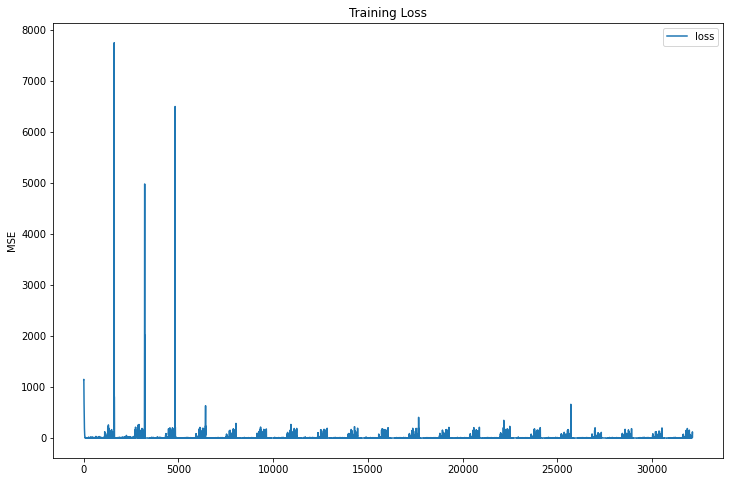

In [67]:
loss_plot(cl_l_tr, "Training Loss")

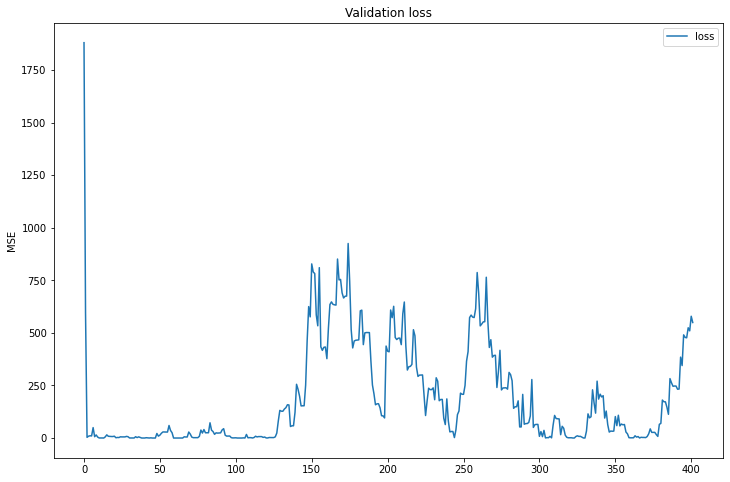

In [68]:
loss_plot(cl_l_val, "Validation loss")

In [69]:
sum(cl_l_val) / len(cl_l_val)

186.73687459289275

#### Batch wise works much better than running through all the previous data before predicting

## CONVOLUTION - BATCHED - ONE SHOT

In [70]:
class BATCH_CONV(nn.Module):
        def __init__(self):
            super(BATCH_CONV, self).__init__()
            # each filter passes over each day seperately and calculates one value for all the features
            self.conv1 = nn.Conv2d(1, 5, kernel_size = (1, 8), stride=1)
            # each filter passes over multiple days to calculate one value
            self.conv2 = nn.Conv2d(5, 1, kernel_size = (11, 1), stride=1)
            self.conv3 = nn.Conv2d(1, 1, kernel_size = (11, 1), stride=1)
            self.fc = nn.Linear(80, 1)
            
        def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = torch.flatten(x)
            out = self.fc(x)
            return out

In [71]:
data2 = batch_data_maker(df[imp_col], peek, lookback, "Close")

In [72]:
# model
model = BATCH_CONV().cuda()
criterion = torch.nn.MSELoss(reduction = 'mean').cuda()
optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
# training
conv_l_tr = []
for t in tqdm(range(50)):
    for i in range(0, len(data2[0])):
        y_train_pred = model(data2[0][i].unsqueeze(0).cuda())
        loss = criterion(y_train_pred.cpu(), data2[1][i])
        conv_l_tr.append(loss.item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:36<00:00,  6.74s/it]


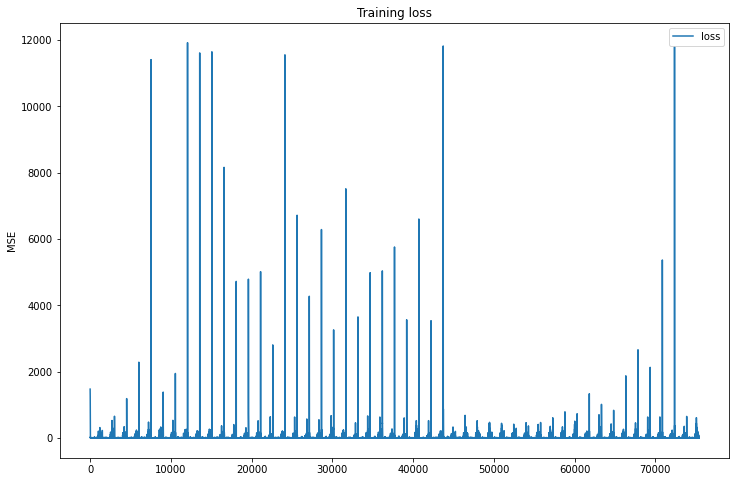

In [73]:
loss_plot(conv_l_tr, "Training loss")

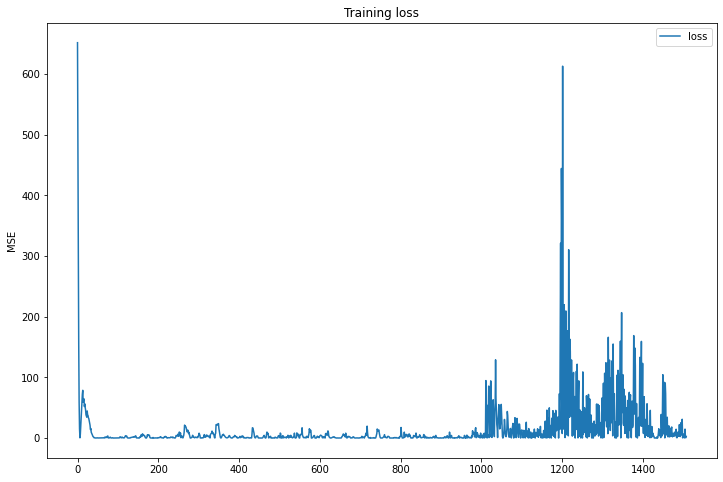

In [74]:
loss_plot(conv_l_tr[-len(data2[0]):], "Training loss")

###### Loss of last epoch

In [75]:
conv_l_val = []
for i in range(0, len(data2[2])):
    y_val_pred = model(data2[2][i].unsqueeze(0).cuda())
    loss = criterion(y_val_pred.cpu(), data2[3][i])
    conv_l_val.append(loss.item())

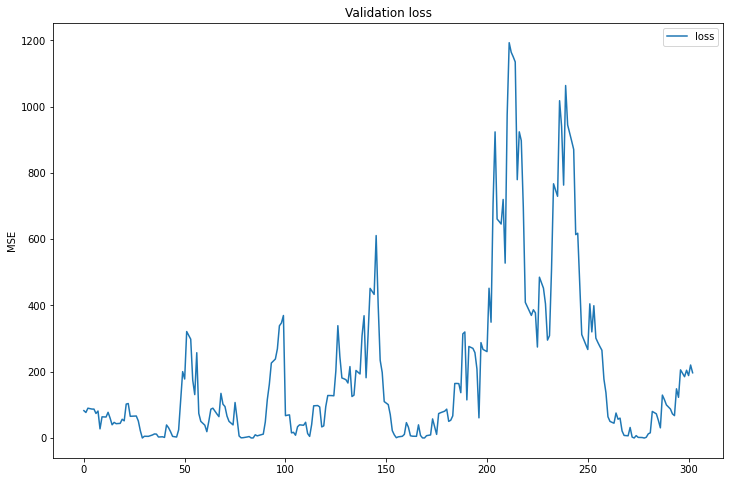

In [76]:
loss_plot(conv_l_val, "Validation loss")

In [77]:
sum(conv_l_val) / len(conv_l_val)

195.91213315571719

# convolution method has given better performance, lets improve that furthur

# HYPERPARAMETER TUNING

In [282]:
class BATCH_CONV(nn.Module):
        def __init__(self, num_feat, channel_size, lookback, kernel_size):
            super(BATCH_CONV, self).__init__()
            
            self.conv0 = nn.Conv2d(1, channel_size, kernel_size = (1, num_feat), stride = 1)
            self.conv_layers = nn.ModuleList()
            
            # making layes with decreasing size
            while True:
                new_channel_size = channel_size // 2
                new_lookback = lookback - kernel_size + 1
                if new_channel_size > 0 and new_lookback > 0:
                    con = nn.Conv2d(channel_size, new_channel_size, kernel_size = (kernel_size, 1), stride = 1)
                    self.conv_layers.append(con)
                    channel_size = new_channel_size
                    lookback = new_lookback
                else:
                    break
            
            self.fc = nn.Linear(lookback*channel_size, 1)
            
        def forward(self, x):
            x = self.conv0(x)
            for c in self.conv_layers:
                x = c(x)
            x = torch.flatten(x)
            out = self.fc(x)
            return out

In [283]:
def training(num_col, first_conv_channels, data, epoches, lookback, kernel_size):
    # make model
    model = BATCH_CONV(num_col, first_conv_channels, lookback, kernel_size)
    criterion = torch.nn.MSELoss(reduction = 'mean')
    optimiser = torch.optim.Adam(model.parameters(), lr = 0.01)
    
    # training
    tr_loss = None 
    for t in tqdm(range(epoches)):
        epoch_losses = []
        for i in range(0, len(data[0])):
            y_train_pred = model(data[0][i].unsqueeze(0))
            loss = criterion(y_train_pred.cpu(), data[1][i])
            epoch_losses.append(loss.item())
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
        tr_loss = sum(epoch_losses) / len(epoch_losses)
    
    # validation
    val_losses = []
    for i in range(0, len(data[2])):
        y_val_pred = model(data[2][i].unsqueeze(0))
        loss = criterion(y_val_pred.cpu(), data[3][i])
        val_losses.append(loss.item())
    val_loss = sum(val_losses) / len(val_losses)
    return tr_loss, val_loss

In [284]:
dic = {
    "first_layer_size": [20],
    "epoches": [1],
    "kernel_size": [11]
}

cols = list(dic.keys()) + ["training", "validation"]
result = pd.DataFrame(columns=cols)

combinations = itertools.product(*list(dic.values()))

for i in combinations:
    t, v = training(
        num_col=len(imp_col),
        first_conv_channels=i[0],
        data=data2,
        epoches=i[1],
        lookback=lookback,
        kernel_size=i[2]
    )
    result.loc[len(result.index)] = list(i) + [round(t, 3), round(v, 3)]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


In [287]:
result.sort_values(by = ["validation", "training"])

,first_layer_size,epoches,kernel_size,training,validation
3,20.0,1.0,11.0,45.518,406.863
4,20.0,1.0,22.0,99.074,512.152
0,10.0,1.0,11.0,22.970,626.545
8,30.0,1.0,33.0,182.936,631.358
1,10.0,1.0,22.0,23.866,691.942
5,20.0,1.0,33.0,110.114,739.179
2,10.0,1.0,33.0,25.692,1124.303
6,30.0,1.0,11.0,82.316,1505.177
7,30.0,1.0,22.0,11251.025,13044.954


In [124]:
pred_data = torch.load("../data/batch_data_maker/pred_data.pt")

In [125]:
model = torch.load("../saved_models/model.pth")

In [126]:
model(pred_data.unsqueeze(0))

tensor([184.5598, 180.4508, 175.9243], grad_fn=<AddBackward0>)

In [131]:
import mlflow
from mlflow.tracking import MlflowClient


model_name = "CNNStockModel"
exp = "7"
remote_server_uri = "http://localhost:5000"

mlflow.set_tracking_uri(remote_server_uri)

runs = mlflow.search_runs(experiment_ids=exp)
lowest = runs["metrics.val_loss"].sort_values(ascending=True)[0]
lowest_run_id = runs[runs["metrics.val_loss"] == lowest]["run_id"][0]

val_loss = None
for mv in MlflowClient().search_runs(experiment_ids=exp):
    mv = dict(dict(mv)["data"])
    id = mv["tags"]['mlflow.log-model.history'].split("run_id")[1][4:].split(",")[0][:-1]
    if id == lowest_run_id:
        val_loss = mv["metrics"]["val_loss"]

print(val_loss)

533.5830889814517
